# Imports

In [1]:
import requests
import json
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.wcs import WCS
import astropy.units as u
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import NoConvergence

from utils import plot_side_by_side

# Astrophotography Annotation

In [2]:
API_URL = "http://nova.astrometry.net/api"


def get_session_key():
    with open("config.json") as config_file:
        config = json.load(config_file)
    apikey = config["apikey"]
    request = requests.post(
        f"{API_URL}/login",
        data={"request-json": json.dumps({"apikey": apikey})},
    ).json()
    return request["session"]


def get_submission_status(subid, poll_interval=10, max_attempts=20):
    submission_url = f"{API_URL}/submissions/{subid}"

    for attempt in range(1 + max_attempts):
        response = requests.get(submission_url)
        if response.status_code == 200:
            submission_status = response.json()
            if submission_status.get("job_calibrations"):
                print("Image Solved!")
                return submission_status
            else:
                print(
                    f"Attempt {attempt}/{max_attempts}: Waiting for image to be solved..."
                )
        else:
            print("Error getting submission status. Status code:", response.status_code)
            print(response.text)
            return None

        time.sleep(poll_interval)

    print(f"Max attempts reached. Submission processing might still be ongoing.")
    return None


def submit_image(session_key, file_path):
    """
    Submit an image file to the Astrometry API for plate-solving.
    Reference:
        Astrometry.net API Documentation: https://astrometry.net/doc/net/api.html
    """
    submission_url = f"{API_URL}/upload"
    files = {
        "request-json": (
            None,
            json.dumps(
                {
                    "publicly_visible": "y",
                    "allow_modifications": "d",
                    "session": session_key,
                    "allow_commercial_use": "d",
                }
            ),
            "text/plain",
        ),
        "file": ("image.jpg", open(file_path, "rb"), "application/octet-stream"),
    }

    response = requests.post(submission_url, files=files)

    if response.status_code == 200:
        print("File submitted successfully!")
        return response.json()
    else:
        print("Error submitting file. Status code:", response.status_code)
        print(response.text)
        return None


def get_job_status(jobid):
    submission_url = f"{API_URL}/jobs/{jobid}"
    response = requests.get(submission_url)
    if response.status_code == 200:
        print("Job status retrieved successfully!")
        return response.json()
    else:
        print("Error retrieving job status. Status code:", response.status_code)
        print(response.text)
        return None


def get_annotations(jobid):
    submission_url = f"{API_URL}/jobs/{jobid}/annotations/"
    response = requests.get(submission_url)
    if response.status_code == 200:
        print("Coordinates retrieved successfully!")
        return response.json()
    else:
        print("Error retrieving coordinates. Status code:", response.status_code)
        print(response.text)
        return None


def download_wcs_file(jobid, save_path):
    url = f'http://nova.astrometry.net/wcs_file/{jobid}'
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print("WCS file downloaded.")
    else:
        print("Error retrieving coordinates. Status code:", response.status_code)
        print(response.text)
        return None


def draw_crosshair(
    image,
    center,
    legend_text,
    size=35,
    gap_size=15,
    thickness=2,
    color=(0, 255, 0),
    font_scale=1.5,
    font_thickness=2,
    text_distance=30,
):
    marked_image = image.copy()
    x, y = center

    # Draw horizontal lines with a gap in the middle
    cv2.line(marked_image, (x - size, y), (x - gap_size, y), color, thickness)
    cv2.line(marked_image, (x + gap_size, y), (x + size, y), color, thickness)

    # Draw vertical lines with a gap in the middle
    cv2.line(marked_image, (x, y - size), (x, y - gap_size), color, thickness)
    cv2.line(marked_image, (x, y + gap_size), (x, y + size), color, thickness)

    # Add text/legend next to the crosshair
    angle_radians = np.radians(45)
    text_position_x = int(x + text_distance * np.cos(angle_radians))
    text_position_y = int(y - text_distance * np.cos(angle_radians))
    text_position = (text_position_x, text_position_y)
    cv2.putText(
        marked_image,
        legend_text,
        text_position,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        color,
        font_thickness,
    )

    return marked_image


def draw_circle(
    image,
    center,
    radius,
    legend_text,
    color=(0, 255, 0),
    thickness=2,
    font_scale=1.5,
    font_thickness=2,
):
    marked_image = image.copy()
    x, y = center

    cv2.circle(marked_image, (x, y), radius, color, thickness)

    # Draw a line from the edge of the circle
    line_length = radius // 3
    line_start = (x + radius, y)
    angle_radians = np.radians(45)
    line_end_x = int(x + radius + line_length * np.cos(angle_radians))
    line_end_y = int(y - line_length * np.cos(angle_radians))
    line_end = (line_end_x, line_end_y)
    cv2.line(marked_image, line_start, line_end, color, thickness)

    # Add text/legend next to the circle
    text_position = (line_end[0] + 10, line_end[1])
    cv2.putText(
        marked_image,
        legend_text,
        text_position,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        color,
        font_thickness,
    )

    return marked_image


def annotate_image(
    annotations,
    image,
    color,
    thickness,
    font_scale,
    font_thickness,
):

    for annotation in annotations:
        radius = int(annotation["radius"])
        x, y = int(annotation["pixelx"]), int(annotation["pixely"])
        name = annotation["names"][0]
        if radius == 0:
            image = draw_crosshair(
                image,
                (x, y),
                legend_text=name,
                color=color,
                thickness=thickness,
                font_scale=font_scale,
                font_thickness=font_thickness,
            )
        else:
            image = draw_circle(
                image,
                (x, y),
                radius=radius,
                legend_text=name,
                color=color,
                thickness=thickness,
                font_scale=font_scale,
                font_thickness=font_thickness,
            )

    return image



In [3]:
def get_image_boundaries(image, image_wcs):
    ny, nx, _ = image.shape
    image_bounds = SkyCoord.from_pixel([0, nx-1, nx-1, 0], [0, 0, ny-1, ny-1], image_wcs)
    ra_min, ra_max = min(image_bounds.ra.deg), max(image_bounds.ra.deg)
    dec_min, dec_max = min(image_bounds.dec.deg), max(image_bounds.dec.deg)
    return ra_min, ra_max, dec_min, dec_max


def detect_stars(image, treshold=5):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Assume stars are the brightest points in the image
    threshold = np.percentile(image, 99)
    # Threshold the image to create a binary imag
    _, binary_image = cv2.threshold(gray_image, threshold, 255, 0)

    blob_extraction_image = image.copy()
    # Detect connected components (blobs) in the binary image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary_image
    )
    center_points = []
    # Loop through the detected blobs and draw a circle on the output image
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > treshold:
            # Get the centroid of the blob
            center = tuple(map(int, centroids[i]))
            center_points.append(center)
            # Draw the circle on the output image
            blob_extraction_image = cv2.circle(
                blob_extraction_image, center, 20, (0, 255, 0), 1
            )
    return np.array(center_points), blob_extraction_image


def get_known_constellation_stars():
    # Query Vizier catalog for known constellation stars
    vizier = Vizier(columns=['HIP', 'RAhms', 'DEdms'], row_limit=-1, catalog='I/239/hip_main')
    result_table = vizier.query_constraints()[0]
    ra = result_table['RAhms']
    dec = result_table['DEdms']
    hip = result_table['HIP']

    ra = [ra_val.replace(' ', ':') for ra_val in ra]
    dec = [dec_val.replace(' ', ':') for dec_val in dec]
    
    constellation_coords = SkyCoord(ra, dec, unit=(u.hourangle, u.deg), frame='icrs')
    
    # Filter out stars without coordinates
    clean = (~np.isnan(constellation_coords.ra) & ~np.isnan(constellation_coords.dec))
    constellation_coords = constellation_coords[clean]
    hip = hip[clean]
    print("Known stars coordinates retrieved.")
    return constellation_coords, hip


def get_star_coordinates(image, image_wcs):
    stars, _ = detect_stars(image)
    star_coords = image_wcs.pixel_to_world(stars[:, 0], stars[:, 1])
    return star_coords


# Match detected stars with constellation stars
def match_stars(star_coords, constellation_coords, tolerance=5*u.arcmin):
    tolerance = 5 * u.arcmin
    idx, d2d, _ = star_coords.match_to_catalog_sky(constellation_coords)
    matches  = star_coords[d2d < tolerance]  # 5 arcmin tolerance
    matched_constellation_stars = constellation_coords[idx][d2d < tolerance]
    # matched_constellation_stars_hr = hr[idx][d2d < tolerance]
    matched_indices = idx[d2d < tolerance]
    print("Star matching finished.")
    return matches, matched_constellation_stars, matched_indices


def get_constellation_lines():
    """Source: https://github.com/Stellarium/stellarium/blob/master/skycultures/modern_iau/constellationship.fab"""
    constellation_lines = {}
    with open('./data/constellationship.fab', 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            constellation = parts[0]
            n_lines = int(parts[1])
            stars = list(map(int, parts[2:2 + 2 * n_lines]))
            constellation_lines[constellation] = [(stars[i], stars[i + 1]) for i in range(0, len(stars), 2)]

    return constellation_lines


def is_within_boundaries(coord, image, image_wcs, offset=0):
    try:
        image_height, image_width, _ = image.shape
        image_height = image_height
        image_width = image_width
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='All-NaN slice encountered')
            pixel_coords = skycoord_to_pixel(coord, image_wcs, origin=1)
        x, y = pixel_coords
        is_within = (offset <= x < image_width) and (offset <= y < image_height)
        return is_within 
    except NoConvergence as e:
        # print(f"Error during WCS transformation: {e}")
        return False


def filter_constellation(constellation_lines, constellation_coords, image, image_wcs, hip):
    # Filter constellations that have at least one star within image boundaries
    filtered_constellations = {}
    for constellation, lines in constellation_lines.items():
        include_constellation = False
        for star1_hip, star2_hip in lines:
            star1_coord = constellation_coords[hip == star1_hip]
            star2_coord = constellation_coords[hip == star2_hip]
            if len(star1_coord) > 0 and len(star2_coord) > 0:
                if (
                    is_within_boundaries(star1_coord, image, image_wcs) 
                    or is_within_boundaries(star2_coord, image, image_wcs)
                    ):
                    include_constellation = True
                    break
        if include_constellation:
            filtered_constellations[constellation] = lines

    return filtered_constellations


def get_constellation_names():
    with open('./data/constellation_names.json', 'r') as file:
        constellation_names = json.load(file)
    return constellation_names


def adjust_text_position(ra, dec, image_boundaries, offset=3):
    ra_min, ra_max, dec_min, dec_max = image_boundaries
    if ra < (ra_min + offset):
        ra += offset
    elif ra > (ra_max - offset):
        ra -= offset

    if dec < (dec_min + offset):
        dec += offset
    elif dec > (dec_max - offset):
        dec -= offset

    return ra, dec


def draw_constellation_lines(
    constellation_coords,
    hip,
    constellation_names,
    image,
    image_wcs,
    filtered_constellations,
    image_boundaries,
    matches,
    matched_constellation_stars,
    draw_stars=False,
    color=(252, 252, 252),
    thickness=2,
    font_scale=4,
    font_thickness=2,
):
    font = cv2.FONT_HERSHEY_DUPLEX
    image = image.copy()
    if draw_stars:
        # Convert matches and matched_constellation_stars to pixel coordinates
        matches_pixel = image_wcs.world_to_pixel_values(matches.ra.deg, matches.dec.deg)
        matched_stars_pixel = image_wcs.world_to_pixel_values(
            matched_constellation_stars.ra.deg, matched_constellation_stars.dec.deg
        )
        # Draw detected stars
        for x, y in zip(matches_pixel[0], matches_pixel[1]):
            cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), 10)  # Red color for detected stars
        # Draw matched constellation stars
        for x, y in zip(matched_stars_pixel[0], matched_stars_pixel[1]):
            cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), 10)  # Green color for matched constellation stars
    annotated_constellations = []
    annotated_stars = []

    for constellation, lines in filtered_constellations.items():
        for star1_hip, star2_hip in lines:
            star1_coord = constellation_coords[hip == star1_hip]
            star2_coord = constellation_coords[hip == star2_hip]
            if len(star1_coord) > 0 and len(star2_coord) > 0:
                # Convert RA/DEC to pixel coordinates
                star1_pixel = image_wcs.world_to_pixel(star1_coord)
                star2_pixel = image_wcs.world_to_pixel(star2_coord)

                # Draw the line
                cv2.line(
                    image,
                    (int(star1_pixel[0]), int(star1_pixel[1])),
                    (int(star2_pixel[0]), int(star2_pixel[1])),
                    color,
                    thickness,
                )

                if (
                    (is_within_boundaries(star1_coord, image, image_wcs, offset=200))
                    and (constellation not in annotated_constellations)
                    and (star1_hip not in annotated_stars)
                ):
                    ra = star1_coord.ra.deg[0]
                    dec = star1_coord.dec.deg[0]
                    adj_ra, adj_dec = adjust_text_position(ra, dec, image_boundaries)
                    adj_pixel = image_wcs.world_to_pixel_values(adj_ra, adj_dec)

                    # Annotate the constellation name
                    cv2.putText(
                        image,
                        constellation_names[constellation],
                        (int(adj_pixel[0]), int(adj_pixel[1])),
                        font,
                        font_scale,
                        color,
                        font_thickness,
                        cv2.LINE_AA,
                    )
                    annotated_constellations.append(constellation)
                    annotated_stars.append(star1_hip)
    return image

In [4]:
def process_image(
    display_image_path,
    annotate_objects,
    annotate_constellations,
    output_path,
    plate_solved_image_path=None,
    color=(0, 255, 0),
    thickness=2,
    font_scale=1.5,
    font_thickness=2,
):
    if plate_solved_image_path is None:
        plate_solved_image_path = display_image_path
    input_image = cv2.imread(plate_solved_image_path)
    session_key = get_session_key()
    response = submit_image(session_key, plate_solved_image_path)
    subid = response["subid"]
    submission_status = get_submission_status(subid)
    jobid = submission_status["jobs"][0]
    job_status = get_job_status(jobid)
    if job_status["status"] == "success":
        print("Job succeeded!")
        display_image = cv2.imread(display_image_path)

        if annotate_objects:
            annotations = get_annotations(jobid)["annotations"]
            annotated_image = annotate_image(
                annotations,
                display_image,
                color=color,
                thickness=thickness,
                font_scale=font_scale,
                font_thickness=font_thickness,
            )
        if annotate_constellations:
            wcs_file_path = 'local_data/wcs.fits'
            download_wcs_file(jobid, save_path=wcs_file_path)
            image_wcs = WCS(wcs_file_path)

            plate_solved_image = cv2.imread(plate_solved_image_path)

            constellation_coords, hip = get_known_constellation_stars()
            star_coords = get_star_coordinates(plate_solved_image, image_wcs)
            matches, matched_constellation_stars, _ = match_stars(star_coords, constellation_coords)
            constellation_lines = get_constellation_lines()
            filtered_constellations = filter_constellation(
                constellation_lines,
                constellation_coords,
                plate_solved_image,
                image_wcs,
                hip
            )
            constellation_names = get_constellation_names()
            image_boundaries = get_image_boundaries(plate_solved_image, image_wcs)

            annotated_image = draw_constellation_lines(
                constellation_coords,
                hip,
                constellation_names,
                display_image,
                image_wcs,
                filtered_constellations,
                image_boundaries,
                matches,
                matched_constellation_stars,
                color=color,
                thickness=thickness,
                font_scale=font_scale,
                font_thickness=font_thickness,
            )

        cv2.imwrite(output_path, annotated_image)

        display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)
        annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        plot_side_by_side(
            [display_image, annotated_image],
            ["Original image", "Annotated image"],
            figsize=(12, 6),
        )
        
    else:
        print("Job failed!")
        return None

File submitted successfully!
Attempt 0/20: Waiting for image to be solved...
Attempt 1/20: Waiting for image to be solved...
Attempt 2/20: Waiting for image to be solved...
Image Solved!
Job status retrieved successfully!
Job succeeded!
WCS file downloaded.


Known stars coordinates retrieved.
Star matching finished.


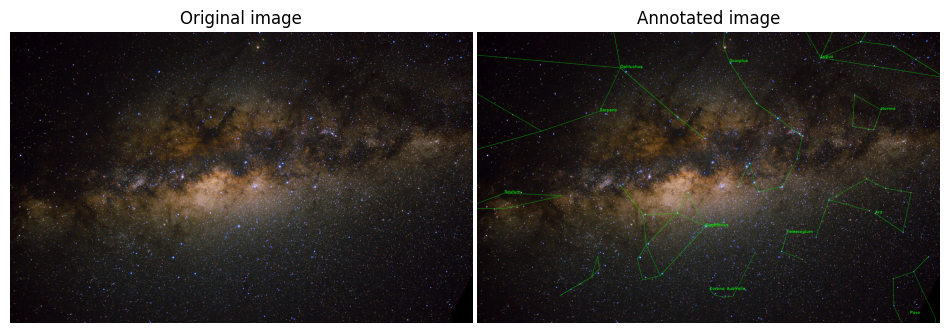

In [13]:
display_image_path = "./local_data/milky_way_core.png"
annotate_objects = False
annotate_constellations = True
output_path = "./local_data/milky_way_core_constellations_annotated.png"
plate_solved_image_path = "./local_data/milky_way_core_unprocessed.png"

process_image(
    display_image_path,
    annotate_objects,
    annotate_constellations,
    output_path,
    plate_solved_image_path,
)

File submitted successfully!
Attempt 0/20: Waiting for image to be solved...
Image Solved!
Job status retrieved successfully!
Job succeeded!
Coordinates retrieved successfully!


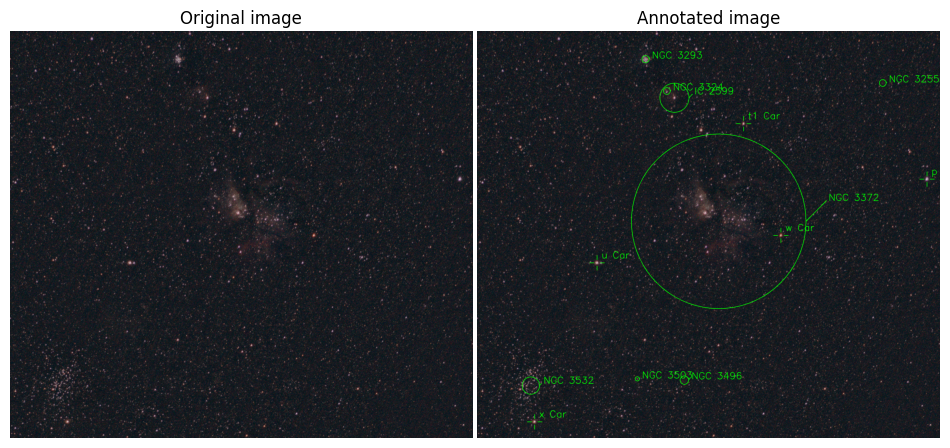

In [11]:
image_path = "./local_data/carina_nebula_jpeg2_cropped.jpg"
output_path = "./local_data/carina_nebula_annotated.jpg"
process_image(image_path, True, False, output_path)